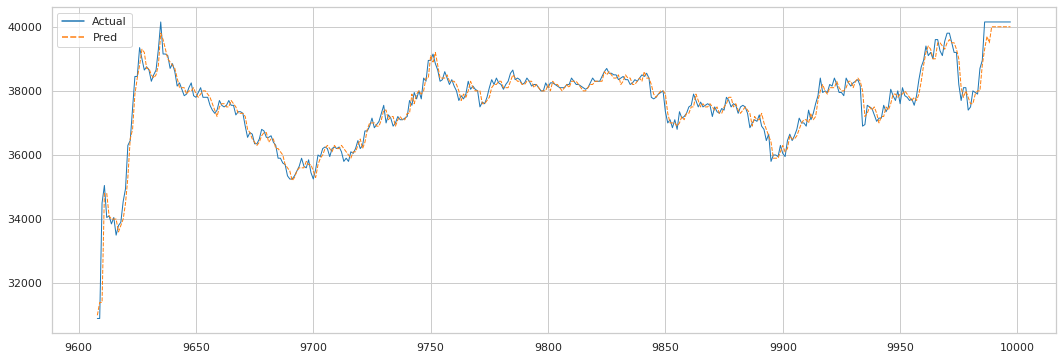

,9608,9609,9610,9611,9612,9613,9614,9615,9616,9617,...,9988,9989,9990,9991,9992,9993,9994,9995,9996,9997
Actual,30900.0,30900.0,34500.0,35050.0,34050.0,34100.0,33850.0,34050.0,33500.0,33800.0,...,40150.0,40150.0,40150.0,40150.0,40150.0,40150.0,40150.0,40150.0,40150.0,40150.0
Pred,31000.0,31400.0,31400.0,34800.0,34800.0,34100.0,34000.0,34000.0,34000.0,33600.0,...,39500.0,40000.0,40000.0,40000.0,40000.0,40000.0,40000.0,40000.0,40000.0,40000.0


In [5]:
code = '038290'          

tr_name = 'TR_SCHART'  

start_date = '00000000'   

end_date = '9999999' 

Lookup = '9999'           

url = 'http://ssecd.roboadvisor.co.kr:9999/' + tr_name + '?0=' + code + '&1=1&2=1' +\
      '&3=' + start_date + '&4=' + end_date + '&5=' + Lookup

from urllib.request import urlopen
url_page = urlopen(url)

import json
url_data = json.loads(url_page.read())

import pandas as pd
data = pd.DataFrame(url_data)

data.columns = ['일자','시간','시가','고가','저가','종가','주가수정계수','거래량수정계수','락구분','단위거래량','단위거래대금']

data = data[['일자', '시간', '시가', '고가', '저가', '종가', '단위거래량', '단위거래대금']]

data = data[::-1]

data['일자_시간'] = data['일자'] + data['시간']

data = data.set_index('일자_시간')

import numpy as np

for step in data.columns[:] : 
    data[step] = data[step].apply(lambda x : np.float(x))

data = data[['시가', '고가', '저가', '종가', '단위거래량', '단위거래대금']]

data_2 = data[['시가', '고가', '저가', '종가', '단위거래량', '단위거래대금']]

for step in data.columns[:-2] : 
    
    data[step] = (data[step] - data[step].min()) / (data[step].max() - data[step].min())
    
for step in data.columns[-2:] : 
    
    data[step] = data[step].apply(lambda x : np.log(x + 1))
    
    data[step] = (data[step] - data[step].min()) / (data[step].max() - data[step].min())
    
data['내일 종가'] = data['종가'].shift(-1)

data = data.dropna()

data = np.array(data)

X_train = data[:,:-1]

Y_train = data[:,-1]

# Dataset For LightGBM
import lightgbm as lgb
train_ds = lgb.Dataset(X_train, label=Y_train) 

# Hypter Parameter Setting
params = {'learning_rate': 0.01, 
          'max_depth': 6, 
          'boosting' : 'gbdt', 
          'objective' : 'regression', 
          'metric' : 'mse', 
          'is_training_metric' : True, 
          'num_leaves' : 144, 
          'feature_fraction' : 0.9, 
          'bagging_fraction' : 0.7, 
          'bagging_freq': 5, 
          'seed' : 1234}

# Model Learning
model = lgb.train(params, train_ds, 1000, train_ds, verbose_eval=0, early_stopping_rounds=100)

# Train Predict
pred = model.predict(X_train)

pred *= np.max(data_2[['종가']]).values - np.min(data_2[['종가']]).values

pred += np.min(data_2[['종가']]).values

pred = pd.DataFrame(pred)

pred.columns = ['내일 예측 가격']

pred = pd.concat([data_2[['종가']][1:].reset_index()[['종가']], pred], axis=1)

pred.columns = ['내일 실제 가격', '내일 예측 가격']

pred['내일 예측 가격'] = pred['내일 예측 가격'].apply(lambda x : round(x,-2))

import warnings
warnings.filterwarnings(action='ignore') 

import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(18,6))
sns.set(style="whitegrid")
pred.columns = ['Actual', 'Pred']
pred = pred[-390:]
sns.lineplot(data=pred, palette="tab10", linewidth=1.0)
plt.show()

pred.T